In [7]:
import numpy as np
import scipy.ndimage as ndi
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
def find_borders(mask, voxel_dims, width=5):
    struct_elem = np.ones([int(np.clip(width / voxel_dims[i], 2, None)) for i in range(len(mask.shape))])

    ### Locate pixels around lesion boundaries
    outer_border = ndi.binary_dilation(mask, struct_elem).astype(int) - mask
    inner_border = mask - ndi.binary_erosion(mask, struct_elem).astype(int)
    total_border = (outer_border + inner_border > 0).astype(np.uint8)
    euclidian_distance = ndi.distance_transform_edt(1 - total_border)

    ### Generate a weightmap putting weights on pixels close to boundaries
    weight_les = 0.5
    border_weight_param = 0.75
    mask_weight = 0.25
    distance_scaler = -0.09
    boundary_weightmap_lesion = border_weight_param * np.clip(np.exp(distance_scaler * euclidian_distance), weight_les, None) + mask_weight * mask

    return boundary_weightmap_lesion.astype(np.float16)

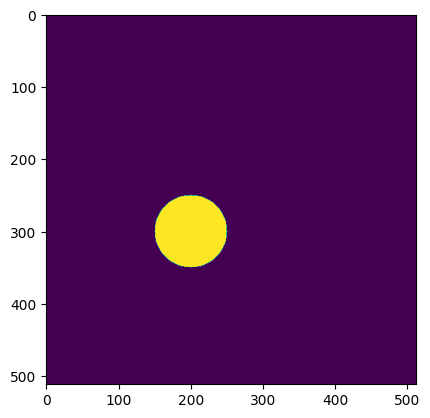

In [20]:
mask = np.zeros((512,512))
cv.circle(mask, (200,300), 50, (1,), -1)
plt.imshow(mask)

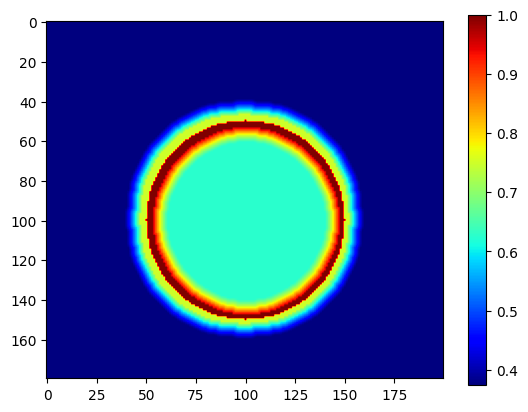

In [46]:
# weightmap = find_borders(mask, (0.8, 0.756, 0.756))
width = 5
voxel_dims = (0.8, 0.756, 0.756)
struct_elem = np.ones([int(np.clip(width / voxel_dims[i], 2, None)) for i in range(len(mask.shape))])

### Locate pixels around lesion boundaries
outer_border = ndi.binary_dilation(mask, struct_elem).astype(int) - mask
inner_border = mask - ndi.binary_erosion(mask, struct_elem).astype(int)
total_border = (outer_border + inner_border > 0).astype(np.uint8)

### Generate a weightmap putting weights on pixels close to boundaries
weight_les = 0.5
exact_euclidian_distance = ndi.distance_transform_edt(1 - total_border)
boundary_weightmap_lesion = 0.75 * np.clip(np.exp(-0.09 * exact_euclidian_distance), weight_les, None) + 0.25 * mask
boundary_weightmap_lesion = boundary_weightmap_lesion.astype(np.float16)

plt.imshow(boundary_weightmap_lesion[200:380, 100:300], cmap="jet")
plt.colorbar()

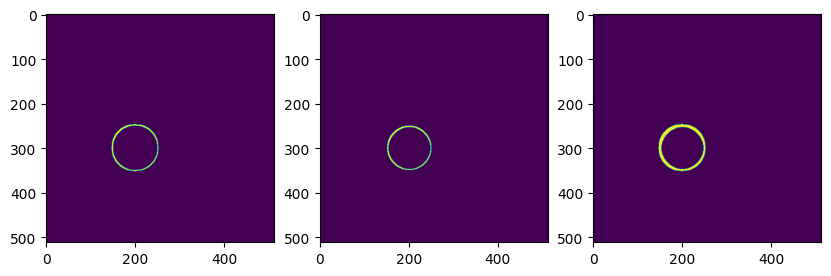

In [31]:
fig, axs = plt.subplots(1,3, figsize=(10, 5))
axs[0].imshow(outer_border)
axs[1].imshow(inner_border)
axs[2].imshow(total_border)

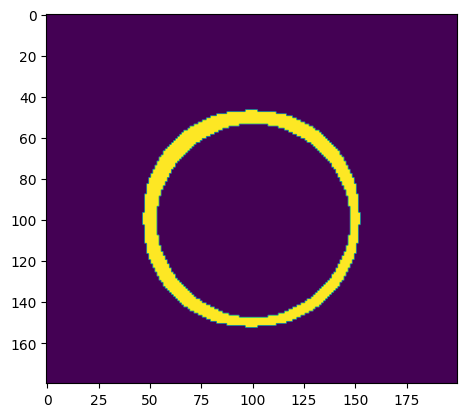

In [45]:
res = inner_border + outer_border
plt.imshow(res[200:380, 100:300])

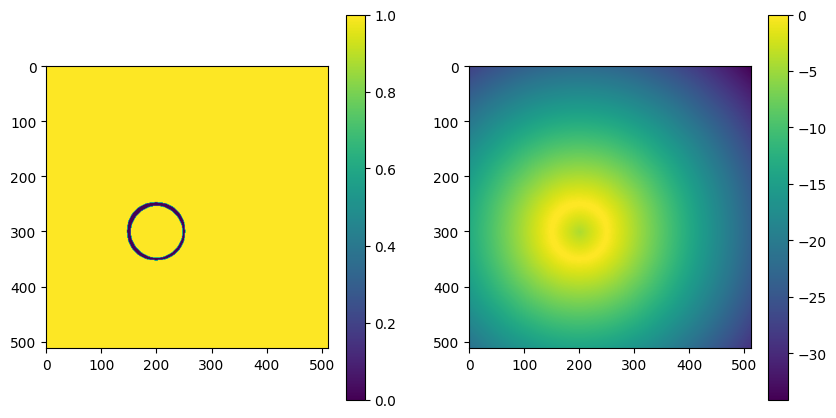

In [89]:
res = 1 - total_border
exact_euclidian_distance = ndi.distance_transform_edt(res)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
res1 = axs[0].imshow(res)
res2 = axs[1].imshow(-0.09 * exact_euclidian_distance)
plt.colorbar(res1, ax=axs[0])
plt.colorbar(res2, ax=axs[1])